## Data preprocessing

The dataset is composed by 6494 headlines, the mean length is 70 characters and the maximum length is 168 characters. I decided to pad all the headlines to the same length (168) with the special character "~" and to add at the begining the special character "^". This is because this implementation only supports fixed length chunks and in order to give to the model the possibility to learn the semantic rules of an italian phrase it should observe one complete phrase as training example.

In [8]:
#load the dateset
import pandas as pd

#load the dataset, no header
df = pd.read_csv('lercio_headlines.csv', header=None)

#record with the maximum number of characters
max = df[0].str.len().max()
print(max)

# pad the headlines with special characters to make them all the same length
df[0] = df[0].str.pad(max, side='right', fillchar='~')

# insert a special character at the beginning of each headline
df[0] = "^" + df[0]

# create a txt file with the headlines
with open('lercio_padded.txt', 'w') as f:
    for line in df[0]:
        f.write(line)

168


## Training and validation setup

The original experiments with this model have been made on the Shaekespeare dataset that is approximately 3 times bigger than the lercio dataset (without padding), since the original experiments were performed with 2000 epoch, i used 6000 epoch of training as baseline.

The other parameters that I played with are the hidden size of the gru units and the number of layer, in addition to the temperature in the generation phase.

It's difficult to systematically asses the quality of the generated headlines, in particular the semantic accuracy. Concerning the correctness of the single words, I prepared a benchmark using a dataset found on Github (https://github.com/napolux/paroleitaliane). The "parole.txt" file contains an list of words in italian (almost complete in my opinion, around 1 milion words), including: compound words, names, surnames, cities and locations, verbs, adjectives, adverbs, etc.
The idea is to use that file to calculate the percetage of correct words generate by the model with different hidden size, number of layers and epochs.

In [1]:
# open the file "parole.txt" and read it creating a dictionary

real_words = {}
with open('./dataset/parole.txt', 'r') as f:
    for p in f:
        real_words[p.strip().lower()] = True

len(real_words)

952734

In [3]:
from generate import generate

def percetage_correct_words(real_words, model_path, temperature, num_titles, len_titles):
    total_words = 0
    wrong_words = 0
    for i in range(num_titles):
        title = generate(model_path, temperature, len_titles)
        # remove the ^ character
        title = title[1:]
        # remove the ~ characters
        title = title.replace('~', '')
        # for each word in the title
        for word in title.split():
            # if the word is not in the dictionary
            if word.lower() not in real_words:
                wrong_words += 1
            total_words += 1
    
    return 1 - wrong_words/total_words          


In [57]:
import numpy as np
import os

hidden_sizes = [100, 200, 300, 400]
layers = [1, 2, 3, 4]
temperatures = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

if (not os.path.exists('./results.npy')):
    results = np.ndarray((len(hidden_sizes), len(layers), len(temperatures)), dtype=float)
    for k , hidden_size in enumerate(hidden_sizes):
        for i, layer in enumerate(layers):
            for j, temperature in enumerate(temperatures):
                results[k][i][j] = percetage_correct_words(
                    real_words=real_words, 
                    model_path=f'./models/lercio_E6000_H{hidden_size}_L{layer}.pt', 
                    temperature=temperature, 
                    num_titles=100, 
                    len_titles=200
                )

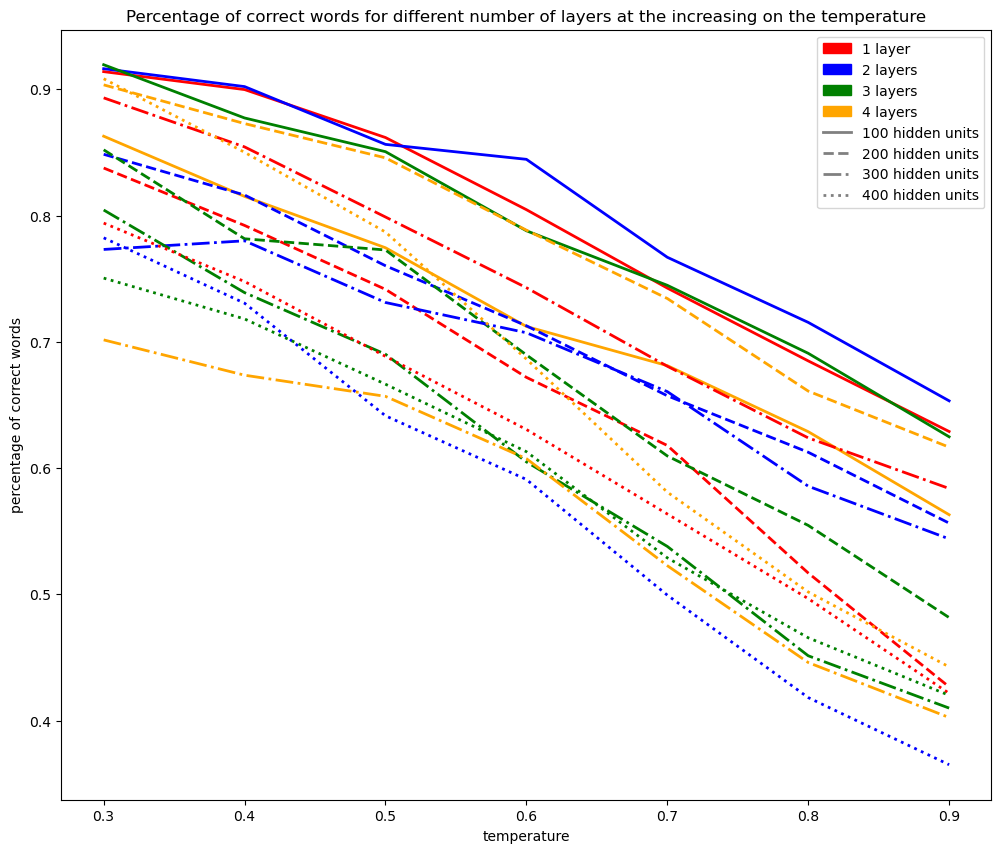

In [56]:
import numpy as np
import matplotlib.pyplot as plt
temperatures = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

results = np.load('results.npy')

# make the plot bigger
plt.figure(figsize=(12, 10))

plt.plot(results[0, 0, 1:], label='1 layer'  , linestyle="-", color='red', linewidth=2)
plt.plot(results[0, 1, 1:], label='2 layers' , linestyle="-", color='blue'  , linewidth=2)
plt.plot(results[0, 2, 1:], label='3 layers' , linestyle="-", color='green', linewidth=2)
plt.plot(results[0, 3, 1:], label='4 layers' , linestyle="-", color='orange',  linewidth=2)

plt.plot(results[1, 0, 1:], linestyle="--", color='red',  linewidth=2)
plt.plot(results[1, 1, 1:], linestyle="--", color='blue',  linewidth=2)
plt.plot(results[1, 2, 1:], linestyle="--", color='green',  linewidth=2)
plt.plot(results[1, 3, 1:], linestyle="--", color='orange',  linewidth=2)

plt.plot(results[2, 0, 1:], linestyle="-.", color='red',  linewidth=2)
plt.plot(results[2, 1, 1:], linestyle="-.", color='blue',  linewidth=2)
plt.plot(results[2, 2, 1:], linestyle="-.", color='green',  linewidth=2)
plt.plot(results[2, 3, 1:], linestyle="-.", color='orange',  linewidth=2)

plt.plot(results[3, 0, 1:], linestyle=":", color='red',  linewidth=2)
plt.plot(results[3, 1, 1:], linestyle=":", color='blue',  linewidth=2)
plt.plot(results[3, 2, 1:], linestyle=":", color='green',  linewidth=2)
plt.plot(results[3, 3, 1:], linestyle=":", color='orange',  linewidth=2)
# personalizad legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
custom_lines = [Patch( color="red", lw=1),
                Patch( color="blue", lw=1),
                Patch( color="green", lw=1),
                Patch( color="orange", lw=1),
                Line2D([0], [0], color="gray", lw=2, linestyle="-"),
                Line2D([0], [0], color="gray", lw=2, linestyle="--"),
                Line2D([0], [0], color="gray", lw=2, linestyle="-."),
                Line2D([0], [0], color="gray", lw=2, linestyle=":"),]

plt.legend(custom_lines, ['1 layer', '2 layers', '3 layers', '4 layers', '100 hidden units', '200 hidden units', '300 hidden units', '400 hidden units'])

plt.xlabel('temperature'), 
plt.ylabel('percentage of correct words')
plt.xticks(np.arange(len(temperatures)), temperatures)
plt.title('''Percentage of correct words for different number of layers at the increasing on the temperature''')
plt.show()